In [1]:
# torch
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from tqdm.notebook import tnrange, tqdm_notebook

# standard libraries
import matplotlib.pyplot as plt
import math
import random
import os
import json
import cv2
import pandas as pd
import numpy as np
import sys
import json

sys.path.append("../")

from dataset import TreeDataset
from transforms import MaskResize
from visualize import BatchVisualizer as BV
import utils

In [2]:
data_configs = {
    'root': '../data/Some Trees Dataset.v12i.coco-segmentation',
    'seed': 42,
    'transforms': {
        'image_transforms': T.Compose([
            T.ToTensor(),
            T.Resize(size=(512, 512))
        ]),
        'mask_transforms': MaskResize(size=(512, 512))
    },
    'batch_size': 2
}

In [3]:
utils.set_seed(data_configs['seed'])
train_set = TreeDataset(data_configs['root'], 
                        'train', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

val_set = TreeDataset(data_configs['root'], 
                        'valid', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

test_set = TreeDataset(data_configs['root'], 
                        'test', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

In [4]:
utils.set_seed(data_configs['seed'])

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)
    
train_loader = DataLoader(train_set, batch_size=data_configs['batch_size'], shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=data_configs['batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=data_configs['batch_size'], shuffle=True, collate_fn=collate_fn)

In [5]:
# instance_seg_lightning.py
import os
from typing import Callable, List, Dict, Any, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from PIL import Image
import numpy as np

# ---------- PredictionProcessor (your provided implementation, extended slightly) ----------
class PredictionProcessor:
    def __init__(self, mask_threshold: float = 0.5, score_threshold: float = 0.5):
        self.mask_threshold = float(mask_threshold)
        self.score_threshold = float(score_threshold)

    def __call__(self, prediction: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # Handle empty predictions
        if not prediction or "masks" not in prediction or "scores" not in prediction:
            return {
                "boxes": torch.empty((0, 4)),
                "labels": torch.empty((0,), dtype=torch.int64),
                "scores": torch.empty((0,)),
                "masks": torch.empty((0, 1, 1, 1))
            }

        keep = prediction["scores"] >= self.score_threshold
        if keep.numel() == 0:
            # nothing kept
            return {
                "boxes": torch.empty((0, 4)),
                "labels": torch.empty((0,), dtype=torch.int64),
                "scores": torch.empty((0,)),
                "masks": torch.empty((0, 1, 1, 1))
            }

        prediction = {k: v[keep] for k, v in prediction.items()}

        if "masks" in prediction and prediction["masks"].numel() > 0:
            # Ensure masks are binary float [N,1,H,W]
            masks = prediction["masks"]
            # Some models return masks as [N, H, W]
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)
            prediction["masks"] = (masks > self.mask_threshold).float()

        return prediction


# ---------- Utilities for mask IoU and matching ----------
def mask_iou_matrix(pred_masks: torch.Tensor, gt_masks: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    """
    pred_masks: [P, H, W] or [P,1,H,W]
    gt_masks: [G, H, W] or [G,1,H,W]
    returns IoU matrix [P, G]
    """
    if pred_masks.dim() == 4:
        pred_masks = pred_masks[:, 0]
    if gt_masks.dim() == 4:
        gt_masks = gt_masks[:, 0]

    if pred_masks.numel() == 0 or gt_masks.numel() == 0:
        return torch.zeros((pred_masks.shape[0], gt_masks.shape[0]), dtype=torch.float32, device=pred_masks.device)

    P = pred_masks.shape[0]
    G = gt_masks.shape[0]

    pred_flat = pred_masks.reshape(P, -1).float()
    gt_flat = gt_masks.reshape(G, -1).float()

    # intersections: P x G
    inter = (pred_flat[:, None, :] * gt_flat[None, :, :]).sum(dim=2)  # (P, G)
    union = (pred_flat.sum(dim=1)[:, None] + gt_flat.sum(dim=1)[None, :] - inter).clamp(min=eps)
    iou = inter / union
    return iou


def compute_pairwise_iou(pred: Dict[str, torch.Tensor], gt: Dict[str, torch.Tensor]) -> torch.Tensor:
    """
    Convenience: get IoU matrix between prediction masks and GT masks for a single image.
    """
    pred_masks = pred.get("masks", torch.empty((0, 1, 1, 1)))
    gt_masks = gt.get("masks", torch.empty((0, 1, 1, 1)))

    # ensure shapes [N,1,H,W] and [M,1,H,W] or empty
    if pred_masks.dim() == 3:
        pred_masks = pred_masks.unsqueeze(1)
    if gt_masks.dim() == 3:
        gt_masks = gt_masks.unsqueeze(1)

    # convert boolean to float
    return mask_iou_matrix(pred_masks, gt_masks)


# ---------- Metrics container ----------
class InstanceSegMetrics:
    """
    Computes metrics over multiple images. Use update(prediction, target) per image.
    At the end call compute() to get aggregated metrics.
    """
    def __init__(self, iou_thresholds: Optional[List[float]] = None):
        # IoU thresholds for mAP approximation
        if iou_thresholds is None:
            # COCO-like thresholds 0.5 : 0.05 : 0.95
            self.iou_thresholds = [round(x, 2) for x in np.arange(0.5, 0.96, 0.05)]
        else:
            self.iou_thresholds = iou_thresholds

        # accumulators
        self.total_gt = 0
        self.total_pred = 0
        self.matched_gts_by_thresh = {t: 0 for t in self.iou_thresholds}  # count of GTs matched at each threshold
        self.total_matches = 0  # matched pairs at IoU 0.5 used for IoU average etc.
        self.sum_iou = 0.0
        self.count_iou = 0

        # for precision/recall counting (at IoU=0.5 default)
        self.tp = 0
        self.fp = 0
        self.fn = 0

    def update(self, prediction: Dict[str, torch.Tensor], gt: Dict[str, torch.Tensor], match_iou_for_relaxed: float = 0.5):
        """
        Update accumulators for one image.
        prediction: processed prediction dict (masks binary, boxes, scores, labels)
        gt: ground truth dict (masks)
        """
        # Get masks
        pred_masks = prediction.get("masks", torch.empty((0, 1, 1, 1)))
        gt_masks = gt.get("masks", torch.empty((0, 1, 1, 1)))

        # normalize dims
        if pred_masks.dim() == 3:
            pred_masks = pred_masks.unsqueeze(1)
        if gt_masks.dim() == 3:
            gt_masks = gt_masks.unsqueeze(1)

        P = pred_masks.shape[0]
        G = gt_masks.shape[0]

        self.total_gt += G
        self.total_pred += P

        if P == 0 and G == 0:
            return

        # IoU matrix shape [P, G]
        iou_mat = mask_iou_matrix(pred_masks, gt_masks)

        # For each IoU threshold, count matched GTs (relaxed: a GT is matched if any pred IoU >= thresh)
        for t in self.iou_thresholds:
            matched_gts = (iou_mat >= t).any(dim=0).sum().item()
            self.matched_gts_by_thresh[t] += int(matched_gts)

        # For standard precision/recall at IoU=0.5: greedily match preds -> gts to count TP/FP/FN
        thresh = 0.5
        if iou_mat.numel() > 0:
            # greedy matching: find best matches
            iou_copy = iou_mat.clone()
            matched_pred = torch.zeros(P, dtype=torch.bool, device=iou_mat.device)
            matched_gt = torch.zeros(G, dtype=torch.bool, device=iou_mat.device)

            while True:
                val, idxs = iou_copy.max(dim=1)  # best GT for each pred
                pred_best_iou, pred_best_gt = torch.max(val, dim=0)
                # Actually simpler: find global max
                if iou_copy.numel() == 0:
                    break
                global_val = iou_copy.max()
                if global_val < thresh:
                    break
                # get indices
                max_idx = (iou_copy == global_val).nonzero()[0]
                p_idx = max_idx[0].item()
                g_idx = max_idx[1].item()
                # mark matched
                matched_pred[p_idx] = True
                matched_gt[g_idx] = True
                # zero out row and column
                iou_copy[p_idx, :] = -1
                iou_copy[:, g_idx] = -1

            tp = int(matched_gt.sum().item())
            fp = int((~matched_pred).sum().item())
            fn = int((~matched_gt).sum().item())

            self.tp += tp
            self.fp += fp
            self.fn += fn

            # gather IoU stats for matched pairs for reporting average IoU
            # compute IoU for matched preds->gt (we'll take max per GT)
            if G > 0:
                best_per_gt, _ = iou_mat.max(dim=0)  # best pred IoU for each gt
                matched_mask = best_per_gt >= 0  # any pred
                # sum IoU of matched ones
                matched_ious = best_per_gt[matched_mask]
                self.sum_iou += matched_ious.sum().item()
                self.count_iou += matched_ious.numel()

    def compute(self) -> Dict[str, float]:
        # relaxed recall per threshold
        relaxed_recall = {}
        for t in self.iou_thresholds:
            total_gt = max(self.total_gt, 1)
            relaxed_recall[f"relaxed_recall_iou_{t:.2f}"] = float(self.matched_gts_by_thresh[t] / total_gt)

        # average IoU across matched instances (if any)
        mean_iou = float(self.sum_iou / self.count_iou) if self.count_iou > 0 else 0.0

        # precision/recall/f1 at IoU=0.5 using counted TP/FP/FN
        precision = float(self.tp / (self.tp + self.fp)) if (self.tp + self.fp) > 0 else 0.0
        recall = float(self.tp / (self.tp + self.fn)) if (self.tp + self.fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        # simplified mAP: mean over thresholds of matched_gt / total_gt (rough approximation)
        map_simple = float(np.mean([self.matched_gts_by_thresh[t] / max(self.total_gt, 1) for t in self.iou_thresholds]))

        return {
            "mean_iou_matched": mean_iou,
            "precision_iou_0.5": precision,
            "recall_iou_0.5": recall,
            "f1_iou_0.5": f1,
            "map_simple": map_simple,
            **relaxed_recall
        }

    def reset(self):
        self.total_gt = 0
        self.total_pred = 0
        self.matched_gts_by_thresh = {t: 0 for t in self.iou_thresholds}
        self.total_matches = 0
        self.sum_iou = 0.0
        self.count_iou = 0
        self.tp = 0
        self.fp = 0
        self.fn = 0


# ---------- LightningModule ----------
class InstanceSegLightningModule(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        lr: float = 1e-4,
        weight_decay: float = 1e-4,
        prediction_processor: Optional[PredictionProcessor] = None,
        inv_transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
        mask_threshold: float = 0.5,
        score_threshold: float = 0.5,
    ):
        """
        model: your Mask R-CNN model (already constructed outside)
        inv_transform: function to inverse any preprocess (accepts tensor image and returns numpy image HxWxC or PIL)
        prediction_processor: instance of PredictionProcessor (if None, one is created)
        """
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay

        self.pred_proc = prediction_processor or PredictionProcessor(mask_threshold=mask_threshold, score_threshold=score_threshold)
        self.inv_transform = inv_transform or (lambda x: x)  # identity if not provided

        # For accumulating validation images/preds
        self._val_storage = []  # list of dicts: {"images": images, "targets": targets, "preds": preds}
        self.metrics = InstanceSegMetrics()
        # track last validation batch for plotting
        self._last_val_batch = None

    def forward(self, images: List[torch.Tensor], targets: Optional[List[Dict[str, torch.Tensor]]] = None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch  # expects (list[Tensor], list[dict])
        # MaskRCNN returns losses dict when targets provided
        losses = self.model(images, targets)
        # losses is a dict
        loss = sum(losses.values())
        # log each loss
        for k, v in losses.items():
            self.log(f"train/{k}", v, on_step=True, on_epoch=False, prog_bar=False, logger=True)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        # compute val losses by passing targets (gives dict)
        with torch.no_grad():
            val_losses = self.model(images, targets)
            # aggregate scalar loss
            val_loss = sum(val_losses.values()) if isinstance(val_losses, dict) else torch.tensor(0.0, device=self.device)

            # run inference to get predictions (list[dict])
            preds = self.model(images)

        # Ensure preds is a list
        if not isinstance(preds, list):
            preds = [preds]

        # Process predictions and update metrics per image
        for img_tensor, gt, pred in zip(images, targets, preds):
            proc_pred = self.pred_proc(pred)
            # Ensure gt masks are binary float and shaped [M,1,H,W]
            gt_masks = gt.get("masks", torch.empty((0, 1, 1, 1)))
            if gt_masks.dim() == 3:
                gt_masks = gt_masks.unsqueeze(1)
            # update metrics
            self.metrics.update(proc_pred, {"masks": gt_masks})

        # store last batch for visualization
        self._last_val_batch = {"images": images, "targets": targets, "preds": preds, "epoch": self.current_epoch}

        # Log val loss
        self.log("val/loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": val_loss}

    def on_validation_epoch_end(self):
        # Compute metrics and log them (CSVLogger will pick them up)
        metrics = self.metrics.compute()
        # log all metrics
        for k, v in metrics.items():
            self.log(f"val/{k}", v, on_step=False, on_epoch=True, prog_bar=False, logger=True)

        # Save visualization for last validation batch
        if self._last_val_batch is not None:
            self._save_last_val_batch_plot(self._last_val_batch)

        # reset for next epoch
        self.metrics.reset()
        self._last_val_batch = None

    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        opt = torch.optim.AdamW(params, lr=self.lr, weight_decay=self.weight_decay)
        # no LR scheduler by default (add if desired)
        return opt

    # ---------- helper to save visualization ----------
    def _save_last_val_batch_plot(self, batch_info: Dict[str, Any]):
        """
        Expects batch_info to contain 'images' (list[Tensor]), 'targets' (list[dict]), 'preds' (list[dict]), 'epoch' (int)
        Uses BV visualizer as described by the user:
            bv = BV(figsize=(16,8))
            fig = bv.visualize_batch((x,y))
            plot_array = bv.fig_to_image(fig[0])
        And saves plot_array to self.logger.log_dir/validation_plots/epoch_{epoch}.png
        """
        images = batch_info["images"]
        targets = batch_info["targets"]
        preds = batch_info["preds"]
        epoch = int(batch_info.get("epoch", self.current_epoch))

        # Inverse transform images and predictions for visualization
        inv_images = []
        inv_targets = []
        inv_preds = []

        for img_tensor, gt, pred in zip(images, targets, preds):
            # inv_transform should accept a tensor and return HxWxC numpy array or PIL image
            try:
                inv_img = self.inv_transform(img_tensor)
            except Exception:
                # fallback: convert tensor to numpy HWC
                inv_img = self._tensor_to_vis(img_tensor)
            inv_images.append(inv_img)

            # For GTs: ensure masks are numpy HxW (or list of masks)
            gt_masks = gt.get("masks", torch.empty((0, 1, 1, 1)))
            if gt_masks.dim() == 3:
                gt_masks = gt_masks.unsqueeze(1)
            # convert to CPU numpy list of HxW arrays
            gt_masks_np = []
            for m in gt_masks:
                m_cpu = m.detach().cpu().numpy()
                # if [1,H,W] -> squeeze
                if m_cpu.ndim == 3:
                    m_cpu = m_cpu[0]
                gt_masks_np.append((m_cpu > 0.5).astype('uint8'))
            inv_targets.append({"masks": gt_masks_np, "boxes": gt.get("boxes", None)})

            # For predicted masks, process and convert
            proc_pred = self.pred_proc(pred)
            p_masks = proc_pred.get("masks", torch.empty((0, 1, 1, 1)))
            if p_masks.dim() == 3:
                p_masks = p_masks.unsqueeze(1)
            p_masks_np = []
            for m in p_masks:
                m_cpu = m.detach().cpu().numpy()
                if m_cpu.ndim == 3:
                    m_cpu = m_cpu[0]
                p_masks_np.append((m_cpu > 0.5).astype('uint8'))
            inv_preds.append({"masks": p_masks_np, "scores": proc_pred.get("scores", None), "boxes": proc_pred.get("boxes", None)})

        # Use BV visualizer. We expect BV to be present.
        try:
            bv = BV(figsize=(16, 8))
            # The user's code expects visualize_batch((x,y)) where x,y are (images, targets).
            fig_list = bv.visualize_batch((inv_images, inv_targets, inv_preds))
            # if visualize_batch returns a list of figs; pick first
            fig = fig_list[0] if isinstance(fig_list, (list, tuple)) else fig_list
            plot_array = bv.fig_to_image(fig)
            # fig_to_image might return PIL or ndarray; normalize to ndarray
            if isinstance(plot_array, (list, tuple)):
                plot_array = plot_array[0]
            if isinstance(plot_array, Image.Image):
                arr = np.array(plot_array)
            else:
                arr = np.asarray(plot_array)
        except Exception as e:
            # BV not available or failed: fallback to a simple grid of images with masks overlay
            arr = self._fallback_grid_image(inv_images, inv_targets, inv_preds)

        # Determine output folder using logger.log_dir
        base_log_dir = getattr(self.logger, "log_dir", None) if self.logger is not None else None
        if base_log_dir is None:
            base_log_dir = os.path.abspath("./logs")
        out_dir = os.path.join(base_log_dir, "validation_plots")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, f"epoch_{epoch:03d}.png")

        # Save arr as PNG
        im = Image.fromarray(arr.astype("uint8"))
        im.save(out_path)
        # Also log path into the logger for traceability
        # Note: CSVLogger won't accept images directly but we log the path as a metric
        # self.log("val/last_val_plot", out_path, on_epoch=True, logger=True)

    def _tensor_to_vis(self, t: torch.Tensor) -> np.ndarray:
        """
        Convert tensor image CxHxW into HxWxC numpy (uint8). Basic normalization applied.
        """
        if isinstance(t, torch.Tensor):
            img = t.detach().cpu()
            if img.dim() == 3:
                c, h, w = img.shape
                arr = img.numpy()
                # assume in [0,1] or ImageNet normalization; try unnormalize if mean/std present in attribute
                arr = arr.transpose(1, 2, 0)  # HWC
                # scale
                arr = np.clip(arr, 0, 1)
                arr = (arr * 255).astype(np.uint8)
            else:
                arr = (img.numpy() * 255).astype(np.uint8)
        else:
            arr = np.asarray(t)
        return arr

    def _fallback_grid_image(self, inv_images, inv_targets, inv_preds):
        """
        Create a simple fallback visualization grid if BV is not available.
        Returns HxWxC ndarray uint8
        """
        # Create small overlays: just show images in a vertical stack with bounding boxes drawn (PIL)
        pil_imgs = []
        for img_arr, gt, pred in zip(inv_images, inv_targets, inv_preds):
            # convert to PIL
            if isinstance(img_arr, np.ndarray):
                pil = Image.fromarray(img_arr.astype("uint8"))
            elif isinstance(img_arr, Image.Image):
                pil = img_arr
            else:
                pil = Image.fromarray(np.asarray(img_arr).astype("uint8"))
            draw = Image.new("RGBA", pil.size)
            # convert to RGBA and return
            pil_imgs.append(pil.convert("RGB"))

        # stack vertically
        widths = [im.width for im in pil_imgs]
        heights = [im.height for im in pil_imgs]
        maxw = max(widths)
        tot_h = sum(heights)
        out = Image.new("RGB", (maxw, tot_h))
        y = 0
        for im in pil_imgs:
            out.paste(im, (0, y))
            y += im.height
        return np.array(out)

In [6]:
from models.resnets import BottleneckFPNBackbone, TreeMaskRCNN

In [7]:
model = TreeMaskRCNN(pretrained=False)

def inv_transform(tensor):
    # tensor: C,H,W with ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
    std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
    img = tensor.cpu() * std + mean
    img = img.clamp(0,1).permute(1,2,0).numpy()
    return (img * 255).astype('uint8')
    
lightning_module = InstanceSegLightningModule(model=model, inv_transform=inv_transform)

C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
x, y = next(iter(test_loader))

In [11]:
lightning_module.eval()
with torch.no_grad():
    yp = lightning_module(x)

In [14]:
model.eval()
with torch.no_grad():
    ypp = model(x)

In [20]:
pp = PredictionProcessor()

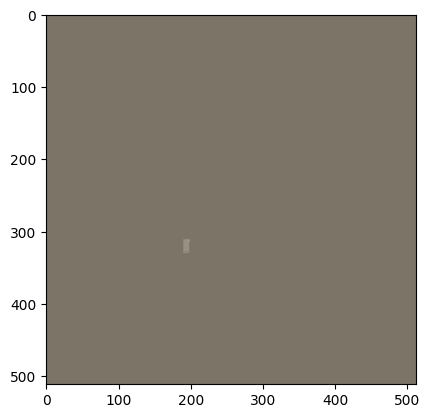

In [49]:
plt.imshow(inv_transform(yp[0]['masks'][0]))